In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Temporal-difference:
- it is a model free algorithm
- it uses the state-vale pair
- it updates the table based on difference between the value of next state and value of current state

Q-leaning:
- type of temporal difference learning
- also called Off-policy TD
- behavioural policy : greedy 
- update policy: some policy pi
- is uses the state-action pair while updating
- it takes the difference between state-action pair of future state that has the maximum value and the state-action pair the policy pi takes

In [2]:
# Q-learning
import numpy as np
# to generate random actions and states from the environment available
import random
# OpenAI which has many inbuilt environments specially for practicing RL problems
import gym 
# to get clear output
from IPython.display import clear_output

In [3]:
# Create environment
# Taxi-v3 is a game 
enviroment = gym.make("Taxi-v3")
enviroment.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
# what state and action available in the environment
print("Number of states:",enviroment.observation_space.n)
print("Number of actions:",enviroment.action_space.n)

Number of states: 500
Number of actions: 6


Update function:

Q(s, a) ← Q(s, a) + α [R + γQ(s’, a’) − Q(s, a)]

In [5]:
# hyper-parameters needed for updation
tot_episodes = 10000
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# Initializing Q table with zeroes
# row: states
# column: actions
Q = np.zeros([enviroment.observation_space.n, enviroment.action_space.n])

In [6]:
# Training
# we use epsilon-greedy for exploration-exploitation
for episode in range(tot_episodes):
    # selecting a random state
    state = enviroment.reset()

    reward = 0
    # to check whether an episode is over or not
    done = False
    
    while not done:
        # we select an action based on epsilon-greedy
        if random.uniform(0, 1) < epsilon:
            action = enviroment.action_space.sample()
        else:
            action = np.argmax(Q[state])
        
        # Giving actions as input to my environment, it returns four values
        next_state, reward, done, info = enviroment.step(action) 
        
        q_val = Q[state, action]
        arg_max = np.max(Q[next_state])

        # Updation formula
        new_q_value = ((1 - alpha)*q_val) + (alpha*(reward + gamma * arg_max))
        
        # Update Q matrix
        Q[state, action] = new_q_value
        state = next_state
    
    if (episode + 1) % 100 == 0:
        clear_output(wait=True)
        print("Episode:",(episode + 1))
        enviroment.render()

Episode: 10000
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


Now the Q table is updated based on the updation formula

In [7]:
# Evaluation
tot_epochs = 0
tot_penalties = 0
tot_episodes = 100

In [8]:
# Positive reward = -1
# Negative Reward = -10

for episode in range(tot_episodes):
    state = enviroment.reset()
    epochs = 0
    penalty = 0
    reward = 0
    
    done = False
    
    while not done:
        action = np.argmax(Q[state])
        state, reward, done, info = enviroment.step(action)

        if reward == -10:
            penalty += 1

        epochs += 1

    tot_penalties += penalty
    tot_epochs += epochs

In [9]:
print("Epochs per episode:",tot_epochs / tot_episodes)
print("Penalties per episode:",tot_penalties / tot_episodes)

Epochs per episode: 29.85
Penalties per episode: 0.0


**REINFORCE ALGORITHM**

In [10]:
import matplotlib.pyplot as plt
import copy 

In [11]:
# hyper-parameters
tot_episodes = 1000
learning_rate = 0.00025
gamma = 0.5
episode_rewards = []

In [12]:
env = gym.make('CartPole-v0').env
no_of_actions = env.action_space.n
no_of_states = env.observation_space.shape[0]

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
# Initialise weights 
w = np.random.rand(no_of_states, no_of_actions)

In [14]:
# Policy is based on a function approximator which is nothing but a neuron
# Matrix muntiplication of my states with weights
def policy(state,w):
    z = state.dot(w)
    exp = np.exp(z)
    return exp/np.sum(exp)

In [15]:
# finding the gradient
def Gradient(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [16]:
def Reinforce_learning(w):
    for episode in range(tot_episodes):

        # set envrironment to any random state available in the environment
        state = env.reset()
        gradients = []
        rewards = []
        tot_reward = 0

        while True:
            prob = policy(state,w)
            action = np.random.choice(no_of_actions, p=prob)
            next_state, reward, done, info = env.step(action)
            next_state = next_state

            # Calculating jacobian softmax gradient 
            dsoftmax = Gradient(prob)[action]
            dlog = dsoftmax / prob[action]
            dlog = np.reshape(dlog,(-1,dlog.shape[0]))
            # reshaping according to matrix multiplication of state and gradient
            state = np.reshape(state,(-1,state.shape[0]))
            grad = state.T.dot(dlog)

            gradients.append(grad)
            rewards.append(reward)

            state = next_state

            if done:
                break

        # Weight updation
        for i in range(len(gradients)):
            w += learning_rate * gradients[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])

        episode_rewards.append(sum(rewards)) 

        print("Epsiode:",episode,"Score:",sum(rewards), end='\r', flush=False) 
        
    return episode_rewards

In [17]:
Rewards = Reinforce_learning(w)

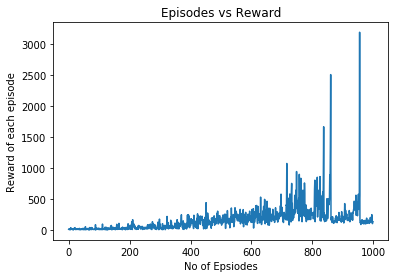

In [18]:
# Plotting 
plt.plot(np.arange(tot_episodes),Rewards)
plt.title("Episodes vs Reward")
plt.xlabel("No of Epsiodes")
plt.ylabel("Reward of each episode")
plt.show()
env.close()

GRID SEARCH CROSS-VALIDATION

GridSearchCV: Grid Search Cross-Validation It is used when we dont know the model parameters. It helps in fiinding the best model parameters.

Hype-paramters: Defined from heuristics

parameters: Defined from experiments

So, you just have to mention the hyper-parameters for the parameters that you want for your model. It itself tells the best values.

In [19]:
from sklearn.model_selection import GridSearchCV

params = {'tot_episodes': [10000,20000,30000], 'learning_rate': [0.00025, 0.05, 0.001], 'gamma': [0.5,0.9,0.7]}

RL = Reinforce_learning(w)

RL_model = GridSearchCV(RL, param_grid = params)

RL_model.fit(Rewards)

RL_model.fit(Tfidf_data_vector)

print("Tfidf model: ")
Tfidfbest = Tfidfmodel.best_estimator_ # Fitting the best model
print(Tfidfmodel.best_estimator_)

print("TfidfBest parameters:")
print(Tfidfmodel.best_params_)

print("TfidfBest Likelihood score:")
print(Tfidfmodel.best_score_)

OFF-POLICY REINFORCE ALGORITHM

In [20]:
off_policy_episode_rewards = []
epsilon = 0.5

In [21]:
# Initialise weights 
w = np.random.rand(no_of_states, no_of_actions)

In [22]:
def Off_Policy_Reinforce_learning(w):
    for episode in range(tot_episodes):

        # set envrironment to any random state available in the environment
        state = env.reset()
        gradients = []
        rewards = []
        tot_reward = 0

        while True:
            prob = policy(state,w)
            if random.uniform(0, 1) < epsilon:
                action = np.random.choice(no_of_actions, p=prob)
            else:
                temp = []
                index = []
                for i in w:
                    l = list(i)
                    temp.append(max(i))
                    index.append(l.index(max(i)))
                action = index[temp.index(max(temp))]
            next_state, reward, done, info = env.step(action)

            # Calculating jacobian softmax gradient 
            dsoftmax = Gradient(prob)[action]
            dlog = dsoftmax / prob[action]
            dlog = np.reshape(dlog,(-1,dlog.shape[0]))
            # reshaping according to matrix multiplication of state and gradient
            state = np.reshape(state,(-1,state.shape[0]))
            grad = state.T.dot(dlog)

            gradients.append(grad)
            rewards.append(reward)

            state = next_state

            if done:
                break

        # Weight updation
        for i in range(len(gradients)):
            w += learning_rate * gradients[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])

        off_policy_episode_rewards.append(sum(rewards)) 

        print("Epsiode:",episode,"Score:",sum(rewards), end='\r', flush=False) 
        
    return off_policy_episode_rewards

In [23]:
Off_Policy_Rewards = Off_Policy_Reinforce_learning(w)

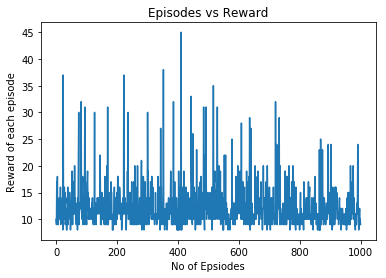

In [24]:
# Plotting 
plt.plot(np.arange(tot_episodes),Off_Policy_Rewards)
plt.title("Episodes vs Reward")
plt.xlabel("No of Epsiodes")
plt.ylabel("Reward of each episode")
plt.show()
env.close()

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [26]:
# hyperparameters
hidden_size = 256
learning_rate = 0.0003

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [27]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_layer = nn.Linear(num_inputs, hidden_size)
        self.critic_lag = nn.Linear(hidden_size, 1)

        self.actor_layer = nn.Linear(num_inputs, hidden_size)
        self.actor_lag = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_layer(state))
        value = self.critic_lag(value)
        
        policy_dist = F.relu(self.actor_layer(state))
        policy_dist = F.softmax(self.actor_lag(policy_dist), dim=1)

        return value, policy_dist

In [28]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size, learning_rate)
    ac_optimizer = optim.Adam(actor_critic.parameters())

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 100 == 0:                    
                    print("Episode:",episode,"Reward:",np.sum(rewards))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        # Converting values and Q-values to float 
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        # Advantage actor-critic
        advantage = Qvals - values
        
        # Finding loss
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        # Resetting the optimizer for next iteration
        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()
        
    return all_rewards,all_lengths,average_lengths

In [29]:
env = gym.make("CartPole-v0")
all_rewards, all_lengths, average_lengths = a2c(env)

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0 Reward: 18.0
Episode: 100 Reward: 35.0
Episode: 200 Reward: 133.0
Episode: 300 Reward: 85.0
Episode: 400 Reward: 117.0
Episode: 500 Reward: 200.0
Episode: 600 Reward: 200.0
Episode: 700 Reward: 200.0
Episode: 800 Reward: 200.0
Episode: 900 Reward: 27.0
Episode: 1000 Reward: 200.0
Episode: 1100 Reward: 200.0
Episode: 1200 Reward: 200.0
Episode: 1300 Reward: 200.0
Episode: 1400 Reward: 43.0
Episode: 1500 Reward: 113.0
Episode: 1600 Reward: 138.0
Episode: 1700 Reward: 108.0
Episode: 1800 Reward: 150.0
Episode: 1900 Reward: 135.0
Episode: 2000 Reward: 200.0
Episode: 2100 Reward: 15.0
Episode: 2200 Reward: 181.0
Episode: 2300 Reward: 200.0
Episode: 2400 Reward: 200.0
Episode: 2500 Reward: 200.0
Episode: 2600 Reward: 200.0
Episode: 2700 Reward: 16.0
Episode: 2800 Reward: 200.0
Episode: 2900 Reward: 200.0


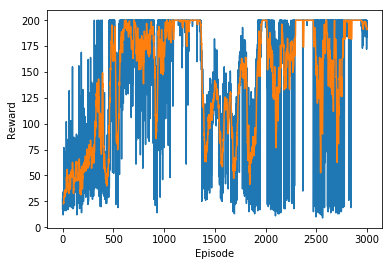

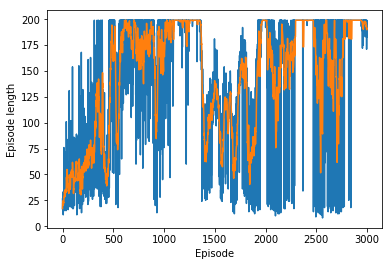

In [30]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.show()

Deep Deterministic Off-Policy

Code Flow:
1. Creating Environment
2. Replay Buffer for off-policy
3. OUNoise for exploration
4. Actor-Critic Network
5. Target Network
6. Finding loss
7. Update network

In [31]:
class NormalizedEnv(gym.ActionWrapper):
    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [32]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [33]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [34]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self,state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [35]:
class DDOPG:
    def __init__(self, env, hidden_size=256, actor_learning_rate=0.0001, critic_learning_rate=0.001, gamma=0.99, tau=0.1, max_memory_size=50000):
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Building Network
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = ReplayBuffer(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Finding loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update actor and critic networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [36]:
env = NormalizedEnv(gym.make("Pendulum-v0"))

agent = DDOPG(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        if done:
            print("episode:",episode,"reward:",np.round(episode_reward, decimals=2))
            break

    rewards.append(episode_reward)
    # Average reward is calulated with recent 10 rewards obtained
    avg_rewards.append(np.mean(rewards[-10:]))

episode: 0 reward: -1309.73
episode: 1 reward: -1470.45
episode: 2 reward: -1332.21
episode: 3 reward: -1335.97
episode: 4 reward: -988.26
episode: 5 reward: -786.22
episode: 6 reward: -1003.1
episode: 7 reward: -663.19
episode: 8 reward: -623.16
episode: 9 reward: -454.04
episode: 10 reward: -377.84
episode: 11 reward: -251.0
episode: 12 reward: -607.4
episode: 13 reward: -743.92
episode: 14 reward: -763.56
episode: 15 reward: -374.81
episode: 16 reward: -251.44
episode: 17 reward: -247.67
episode: 18 reward: -625.0
episode: 19 reward: -4.1
episode: 20 reward: -615.09
episode: 21 reward: -367.2
episode: 22 reward: -359.58
episode: 23 reward: -382.48
episode: 24 reward: -495.53
episode: 25 reward: -376.28
episode: 26 reward: -480.27
episode: 27 reward: -478.45
episode: 28 reward: -131.22
episode: 29 reward: -125.36
episode: 30 reward: -374.74
episode: 31 reward: -333.34
episode: 32 reward: -486.14
episode: 33 reward: -244.05
episode: 34 reward: -497.4
episode: 35 reward: -246.9
episode

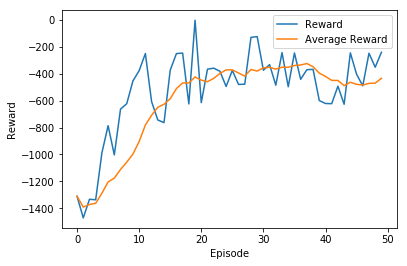

In [37]:
plt.plot(rewards,label="Reward")
plt.plot(avg_rewards,label="Average Reward")
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()